<br>
<br>
# Predict Blood Donations
<br>
<br>

The objective of this notebook is to predict if a blood donor will donate within a given time window, given parameters such as months  since last donation (recency), number of donations made (frequency) , total volume of blood donated (cc) [monetary], months since first donation (time).

This is a warm-up problem in an ongoing competition at https://www.drivendata.org/competitions/2/warm-up-predict-blood-donations/page/7/

In [602]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from imblearn import over_sampling as os
from imblearn import under_sampling as us
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced
from collections import Counter
RANDOM_STATE = 2017

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

# sns.set()

%matplotlib inline

In [323]:
from jupyterthemes import jtplot

jtplot.style('grade3', context='poster', fscale=1.5)
jtplot.style(ticks=True, grid=False)

In [31]:
df = pd.read_csv("transfusion.data.txt")

In [498]:
df.head()

,recency,frequency,monetary,time,class
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [33]:
df.columns = ['recency', 'frequency', 'monetary', 'time', 'class']

In [499]:
df.head()

,recency,frequency,monetary,time,class
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


<br>
<br>
class 1 => the donor donated blood in March 2007 [let's call them donors]
<br>
class 0 => the donor did not donate blood in March 2007 [ let's call them non-donors ]
<br>
<br>

<br>
<br>
** Number of instances of each class **
<br>
<br>

In [35]:
df['class'].value_counts()

0    570
1    178
Name: class, dtype: int64

<br>
<br>
we see that there is a class imbalance problem here. We can fix this issue by oversampling the minority class (1) or undersampling the majority class.
<br>
<br>


<br>

---
## EDA
---
<br>
<br>

Let's explore the dataset and find out if we can get some interesting insights.

<br>

In [495]:
def ecdf(data):
    """
    returns empirical CDF of a data
    """
    n= len(data)
    x = np.array(sorted(data))
    y = np.arange(1,n+1)/(n*1.0)
    return x,y
    

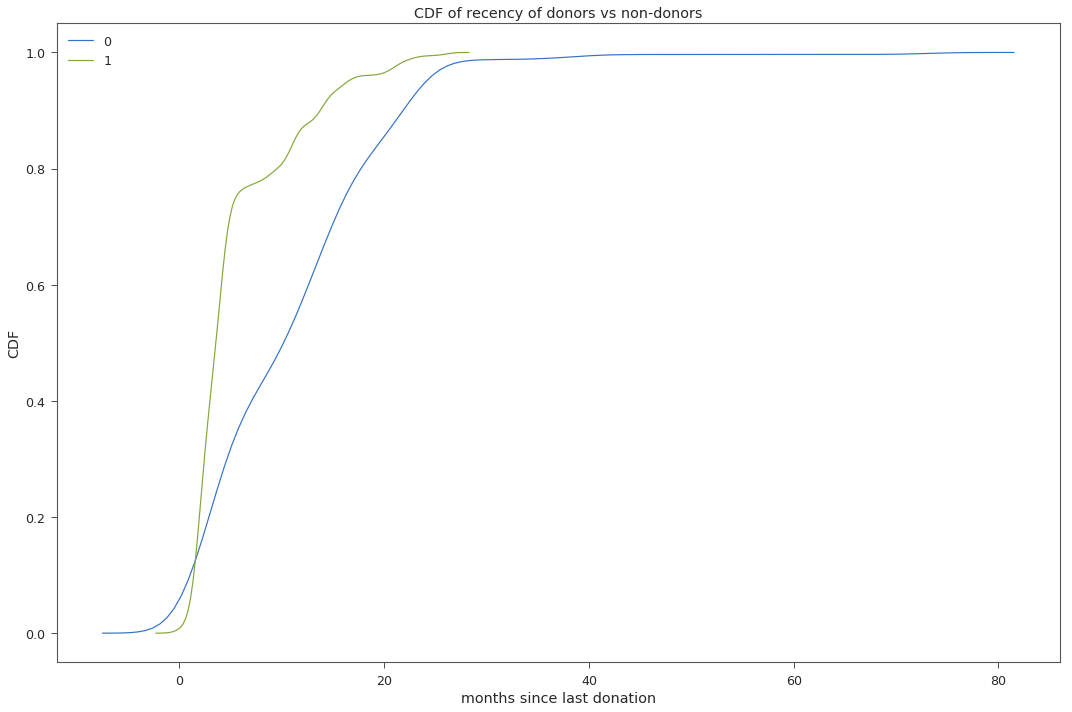

In [517]:
plt.figure(figsize=(15,10))
_ = sns.kdeplot(df[df['class']==0]['recency'],cumulative=True,label='0')
_ = sns.kdeplot(df[df['class']==1]['recency'],cumulative=True,label='1')
_ = plt.xlabel('months since last donation')
_ = plt.ylabel('CDF')
_ = plt.title('CDF of recency of donors vs non-donors')
plt.show();

<br>
<br>
People who are likely to donate blood again have donated blood more recently. The curve representing the CDF of donors (class 1) grows faster with less recency values than CDF of non-donors (class 0).
<br>
<br>

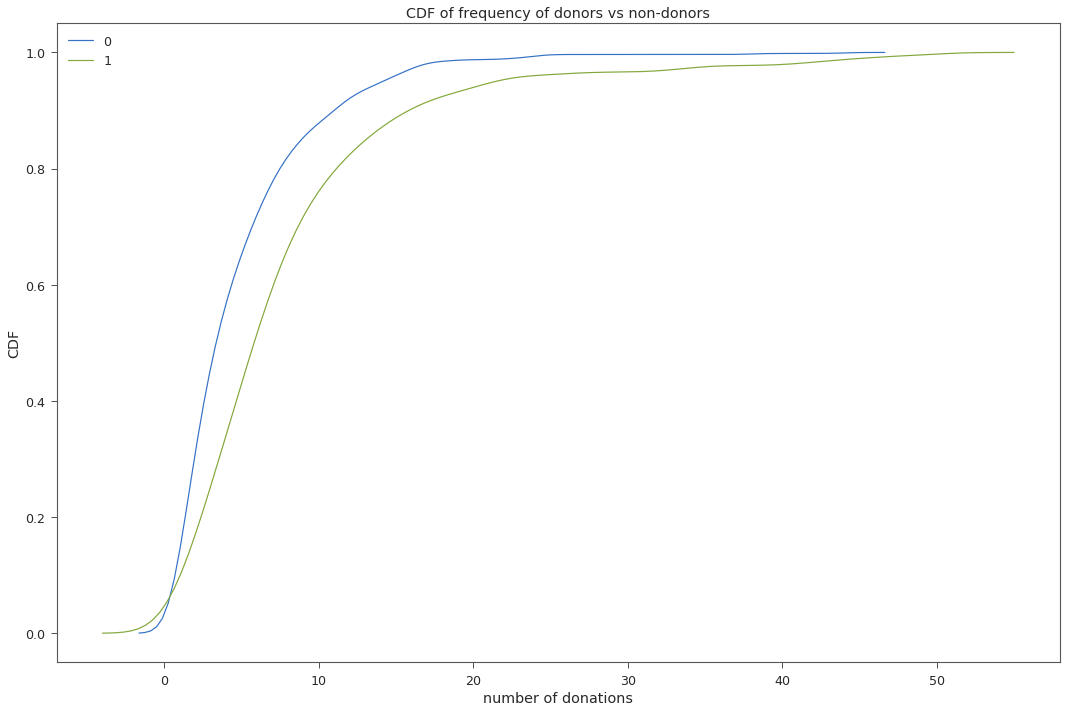

In [518]:
plt.figure(figsize=(15,10))
_ = sns.kdeplot(df[df['class']==0]['frequency'],cumulative=True,label='0')
_ = sns.kdeplot(df[df['class']==1]['frequency'],cumulative=True,label='1')
_ = plt.xlabel('number of donations')
_ = plt.ylabel('CDF')
_ = plt.title('CDF of frequency of donors vs non-donors')
plt.show()

<br>
<br>
From the above plot, we observe that donors donate more frequently than non-donors
<br>
<br>

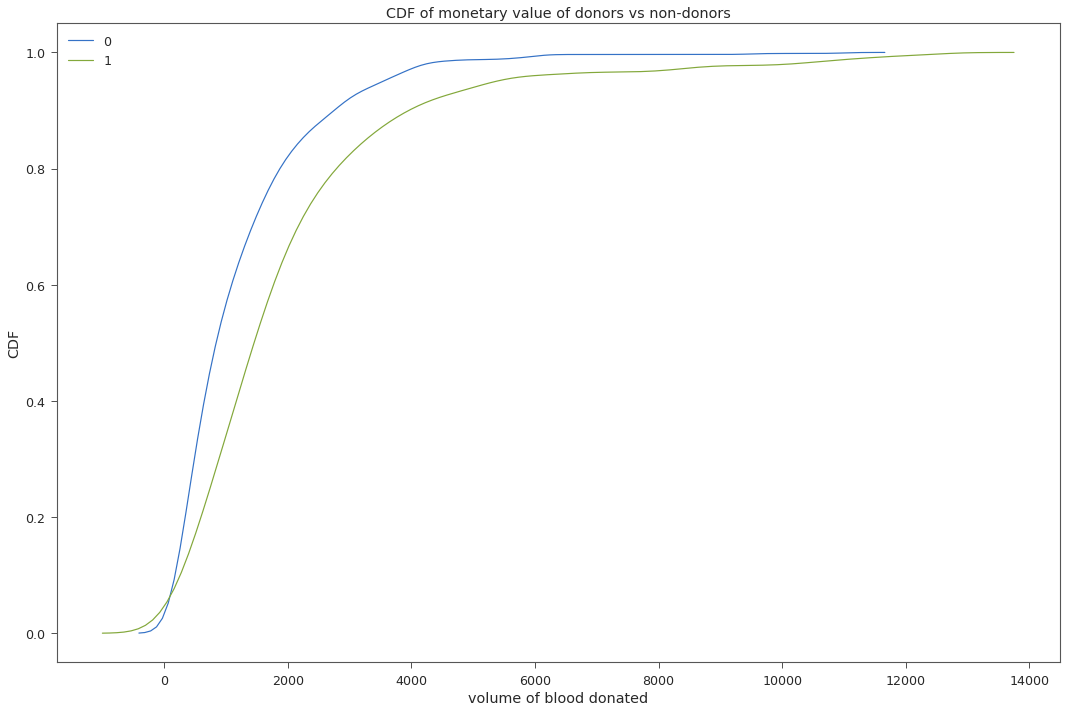

In [519]:
plt.figure(figsize=(15,10))
_ = sns.kdeplot(df[df['class']==0]['monetary'],cumulative=True,label='0')
_ = sns.kdeplot(df[df['class']==1]['monetary'],cumulative=True,label='1')
_ = plt.xlabel('volume of blood donated')
_ = plt.ylabel('CDF')
_ = plt.title('CDF of monetary value of donors vs non-donors')
plt.show()

<br>
<br>
The above CDF looks similar to the previous one. Frequency and monetary values are highly correlated. Here again, donars donate more volumne of blood than non-donors
<br>
<br>

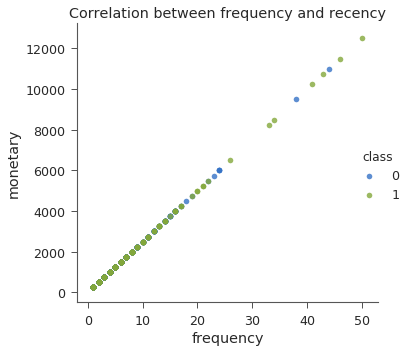

In [511]:
plt.figure(figsize=(15,10));
_ = sns.lmplot(x='frequency',
               y='monetary',
               hue='class',
               fit_reg=False,
               data=df);
_ = plt.title("Correlation between frequency and recency");
plt.show();

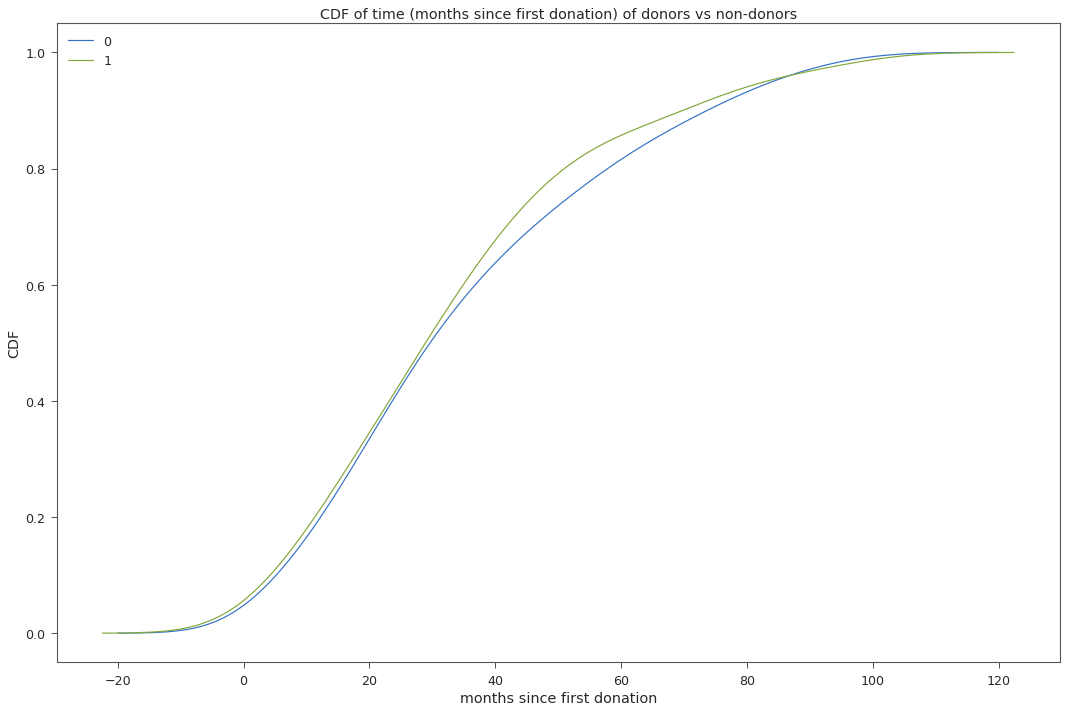

In [668]:
plt.figure(figsize=(15,10))
_ = sns.kdeplot(df[df['class']==0]['time'],cumulative=True,label='0')
_ = sns.kdeplot(df[df['class']==1]['time'],cumulative=True,label='1')
_ = plt.xlabel('months since first donation')
_ = plt.ylabel('CDF')
_ = plt.title('CDF of time (months since first donation) of donors vs non-donors')
plt.show()

<br>
<br>
CDF of months since first donations is not so differentiable between the two classes.
<br>
<br>

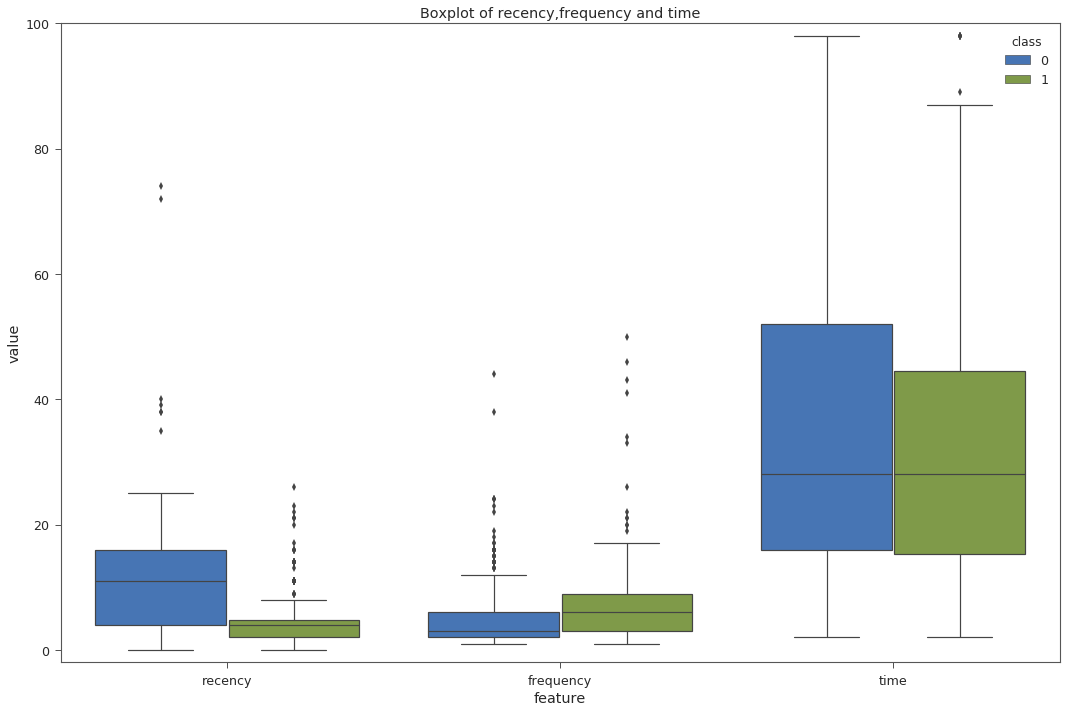

In [684]:
df_long = pd.melt(df,id_vars='class',var_name='feature')
plt.figure(figsize=(15,10))
_ = sns.boxplot(x='feature',y='value',hue='class',data=df_long[df_long.feature!='monetary'])
plt.margins(0.02)
_ = plt.title('Boxplot of recency,frequency and time')
plt.show()

<br>
<br>
we see that there are few outliers in recency and frequency for each of the classes. Should we remove them? What's the story behind these outliers?
<br>
<br>


---

** Prepare Data **

---

In [648]:
from sklearn.model_selection import train_test_split

<br>
<br>
Let's split our dataset into training and testing. We'll drop 'monetary' feature from our training data since it has high correlation to 'frequency'. It is a good practise to standardise our data.
<br>
<br>

In [678]:
x_train, x_test, y_train,y_test = train_test_split(df.drop(['class','monetary'],axis=1), df['class'], test_size = 0.1, random_state=2017)

In [679]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [680]:
x_train_scaled.mean(),x_train_scaled.std()

(-8.7982012847956928e-19, 1.0)

In [681]:
x_test_scaled.mean(),x_test_scaled.std()

(0.058943449584060933, 1.155008299202017)

<br>
<br>
**submission**
<br>
<br>

In [765]:
def create_submission(clf):
    test = pd.read_csv("test.csv")
    test.columns = ['id','recency','frequency','monetary','time']
    submit_id, submit_test = test['id'] , test.drop(['id','monetary'],axis=1)
    submit_test_scaled = scaler.transform(submit_test) #scale the data
    predictions = clf.predict_proba(submit_test_scaled)
    predictions = predictions[:,1] #only predictions for class-1 needs to be submitted
    pred_report = pd.DataFrame(predictions.tolist(),index=submit_id,columns=["Made Donation in March 2007"])    
    return pred_report

---

## Utility Functions

---

In [771]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Accent):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return


def prediction_report(true_label,predicted_label,classes=[0,1]):
    
    report = classification_report(true_label, predicted_label)
    print "classification report:\n",report
    cnf_matrix = confusion_matrix(true_label, predicted_label)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(15,10))
    plot_confusion_matrix(cnf_matrix, classes=classes,title='Confusion matrix, without normalization')
    return



---
## Models
---

<br>
<br>
**SVC**
<br>
<br>

In [772]:
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import log_loss

[LibSVM]
Log loss:  0.515342947631
classification report:
             precision    recall  f1-score   support

          0       0.81      0.97      0.88        58
          1       0.67      0.24      0.35        17

avg / total       0.78      0.80      0.76        75

Confusion matrix
[[56  2]
 [13  4]]


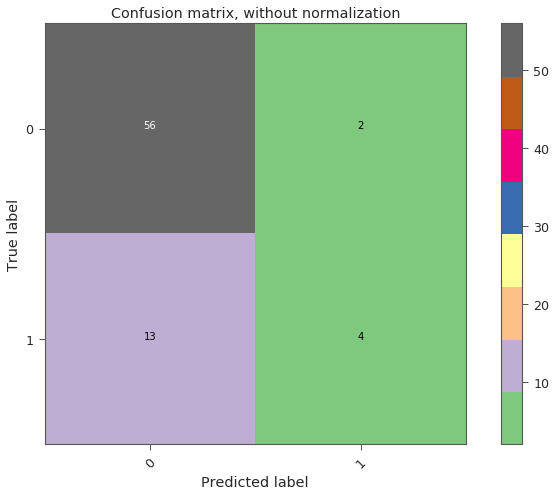

In [773]:
svc = SVC(verbose=1,random_state=2017,probability=True);
svc.fit(x_train_scaled,y_train);

y_pred = svc.predict_proba(x_test_scaled)
print "\nLog loss: ",log_loss(y_test,y_pred[:,1])

true_label = y_test
predicted_label = svc.predict(x_test_scaled)
prediction_report(true_label,predicted_label)

In [749]:
pred_report = create_submission(svc)
pred_report.to_csv("submission.v2.svc.csv")

<br>
<br>
**Logistic Regression**
<br>
<br>

In [776]:
from sklearn.linear_model import LogisticRegression


Log loss:  0.52176733679
classification report:
             precision    recall  f1-score   support

          0       0.80      0.97      0.88        58
          1       0.60      0.18      0.27        17

avg / total       0.75      0.79      0.74        75

Confusion matrix
[[56  2]
 [14  3]]


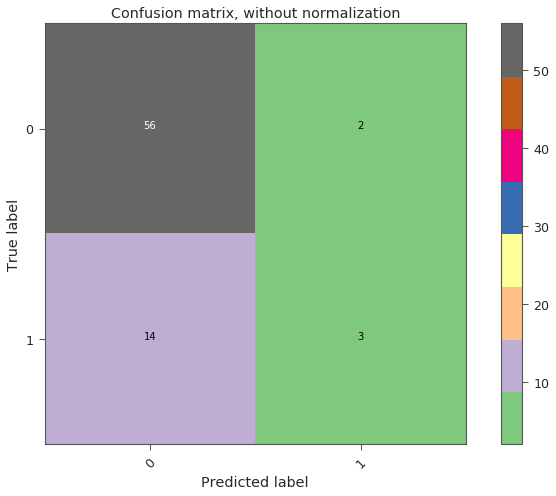

In [778]:
logit_model = LogisticRegression(random_state=2017)
logit_model.fit(x_train_scaled,y_train)
y_pred = logit_model.predict_proba(x_test_scaled)
print "\nLog loss: ",log_loss(y_test,y_pred[:,1])

true_label = y_test
predicted_label = logit_model.predict(x_test_scaled)
prediction_report(true_label,predicted_label)

<br>
<br>
**Random Forest**
<br>
<br>

In [752]:
from sklearn.ensemble import RandomForestClassifier


Log loss:  0.613861430599
classification report:
             precision    recall  f1-score   support

          0       0.82      0.81      0.82        58
          1       0.39      0.41      0.40        17

avg / total       0.73      0.72      0.72        75

Confusion matrix
[[47 11]
 [10  7]]


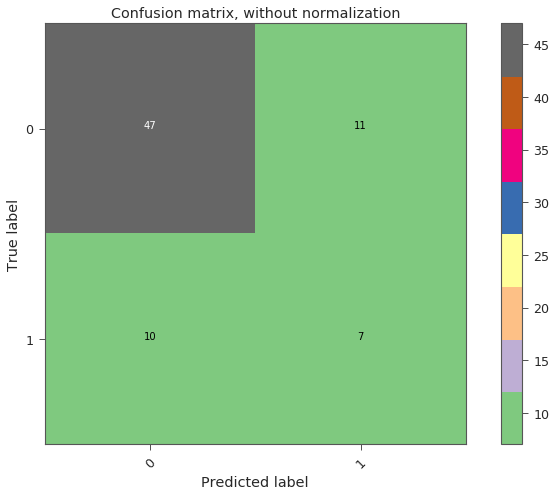

In [819]:
rf = RandomForestClassifier(n_estimators=400,max_depth=6,class_weight='balanced',n_jobs=4,random_state=2017)
rf.fit(x_train_scaled,y_train)

y_pred = rf.predict_proba(x_test_scaled)
print "\nLog loss: ",log_loss(y_test,y_pred[:,1])

true_label = y_test
predicted_label = rf.predict(x_test_scaled)
prediction_report(true_label,predicted_label)

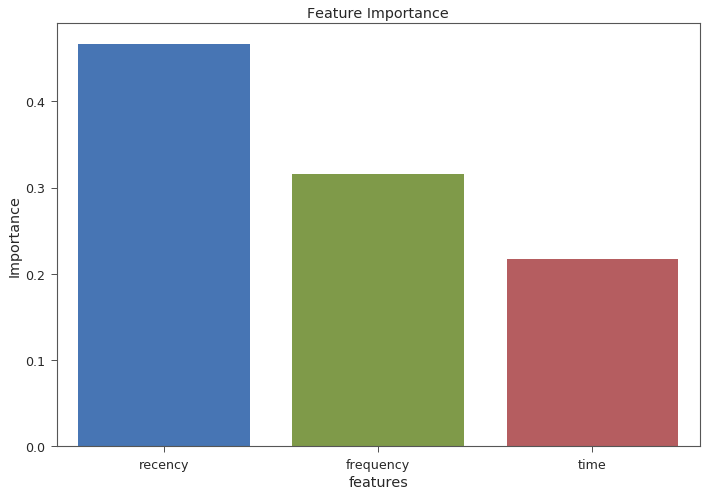

In [781]:
feature_imp_df = pd.DataFrame(zip(x_train.columns,rf.feature_importances_))
feature_imp_df.columns = ['features','imp']

plt.figure(figsize=(10,7))
_ = sns.barplot(x='features', y = 'imp', data=feature_imp_df)
_ = plt.ylabel('Importance')
_ = plt.title("Feature Importance")
plt.show()

In [662]:
def plot_history(history):
    
    #plot training and validation loss
    f, axarr = plt.subplots(2, sharey=True,figsize=(14,10))
    loss,acc,val_loss,val_acc = history.params['metrics']

    _ = axarr[0].plot(history.history[loss],'r',label='training')
    _ = axarr[0].plot(history.history[val_loss],'b',label='validation')
    _ = plt.xlabel('epochs')
    _ = plt.ylabel('loss')
    _ = axarr[0].set_title('training/validation loss over epochs')
    _ = axarr[0].legend()

    #plot training and validation accuracy    
    _ = axarr[1].plot(history.history[acc],'r',label='training')
    _ = axarr[1].plot(history.history[val_acc],'b',label='validation')
    _ = plt.xlabel('epochs')
    _ = plt.ylabel('accuracy')
    _ = axarr[1].set_title('training/validation accuracy over epochs')
    _ = plt.legend()
    
    plt.show()
    
    return


<br>
<br>
MLP
<br>
<br>

In [820]:
#set-up early-stopping monitor

early_stopping_monitor = EarlyStopping(monitor='val_loss',patience=5)


In [821]:
from keras.utils import to_categorical

Train on 538 samples, validate on 135 samples
Epoch 1/20
538/538 [==============================] - 0s - loss: 0.6142 - acc: 0.7193 - val_loss: 0.6027 - val_acc: 0.7333
Epoch 2/20
538/538 [==============================] - 0s - loss: 0.5354 - acc: 0.7677 - val_loss: 0.5526 - val_acc: 0.7333
Epoch 3/20
538/538 [==============================] - 0s - loss: 0.5245 - acc: 0.7677 - val_loss: 0.5160 - val_acc: 0.7333
Epoch 4/20
538/538 [==============================] - 0s - loss: 0.5171 - acc: 0.7677 - val_loss: 0.4947 - val_acc: 0.7333
Epoch 5/20
538/538 [==============================] - 0s - loss: 0.4980 - acc: 0.7686 - val_loss: 0.4802 - val_acc: 0.7333
Epoch 6/20
538/538 [==============================] - 0s - loss: 0.4965 - acc: 0.7658 - val_loss: 0.4660 - val_acc: 0.7407
Epoch 7/20
538/538 [==============================] - 0s - loss: 0.5004 - acc: 0.7658 - val_loss: 0.4588 - val_acc: 0.7778
Epoch 8/20
538/538 [==============================] - 0s - loss: 0.5027 - acc: 0.7714 - val_l

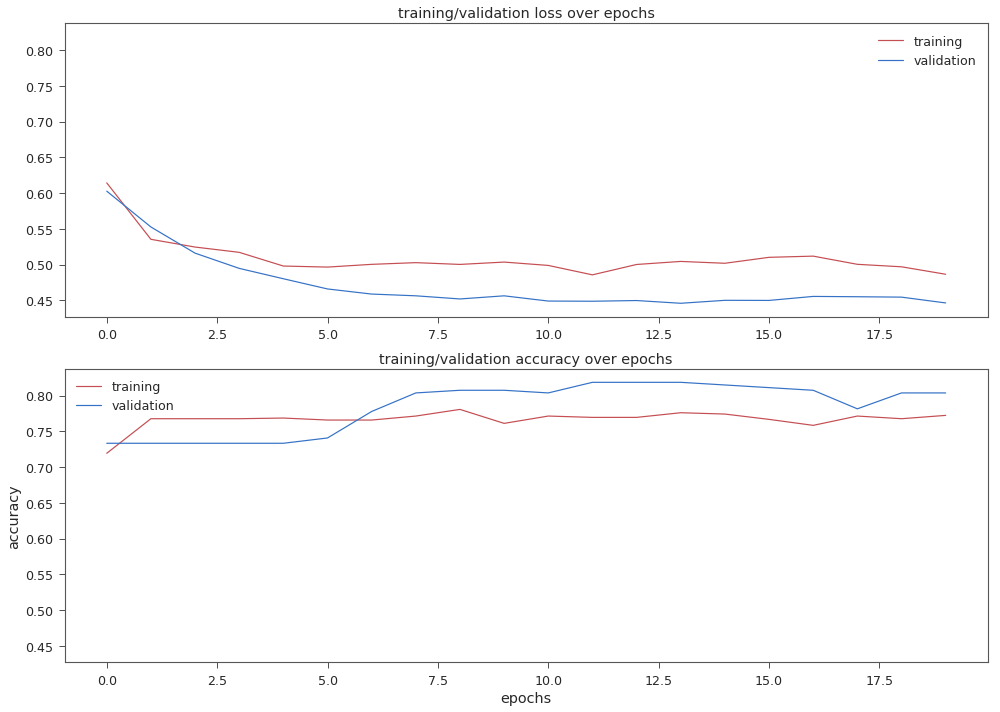

In [876]:
np.random.seed(2017)
model = Sequential()
model.add(Dropout(0.2,input_shape=(x_train_scaled.shape[1],)))
model.add(Dense(100,activation='relu',input_shape=(x_train_scaled.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100,activation='relu'))
model.add(Dense(2,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(x_train_scaled,to_categorical(y_train),epochs=20,verbose=1,validation_split=0.2,callbacks=[early_stopping_monitor])
plot_history(history)

In [880]:
result = model.evaluate(x_test_scaled,to_categorical(y_test),verbose=False)
print "Log loss {}, Accuracy {}".format(result[0], result[1])

Log loss 0.521903313001, Accuracy 0.773333336512


In [878]:
report = create_submission(model)
report.to_csv("submission.v3.mlp.csv")

 32/200 [===>..........................] - ETA: 0s

classification report:
             precision    recall  f1-score   support

          0       0.81      0.95      0.87        58
          1       0.57      0.24      0.33        17

avg / total       0.76      0.79      0.75        75

Confusion matrix
[[55  3]
 [13  4]]


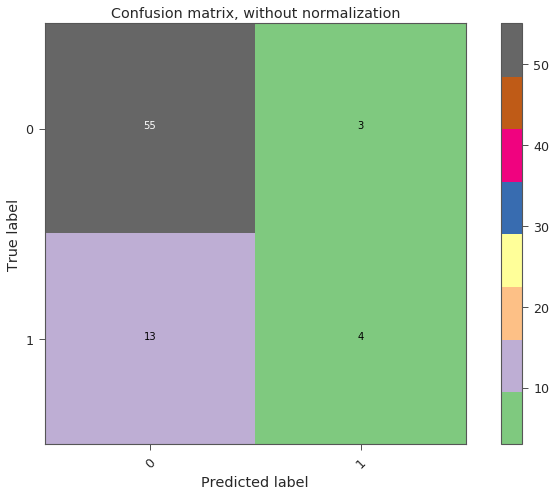

In [879]:
# prediction_report(model,x_test_scaled,y_test)
predicted_label = model.predict_classes(x_test_scaled,verbose=False)
true_label = y_test.values
prediction_report(true_label,predicted_label)